In [ ]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Function to load all images from a folder
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)

            # Ensure the image has the right shape (H, W, C)
            if len(img.shape) == 3:  # Color image
                images.append(img)
            elif len(img.shape) == 2:  # Grayscale image
                images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
            else:
                print(f"Skipping {filename}: Unsupported image shape {img.shape}")

    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

# Paths to the benign and malignant directories
benign_dir = "/content/drive/MyDrive/Kaggle_filtered/benign"
malignant_dir = "/content/drive/MyDrive/Kaggle_filtered/malignant"

# Load images from benign and malignant folders
benign_images = load_images_from_folder(benign_dir)
malignant_images = load_images_from_folder(malignant_dir)

Loaded 1800 images from /content/drive/MyDrive/Kaggle_filtered/benign
Loaded 1497 images from /content/drive/MyDrive/Kaggle_filtered/malignant


In [ ]:
benign_images = benign_images.astype(np.float32) / 255.0
malignant_images = malignant_images.astype(np.float32) / 255.0

In [ ]:
# Function to generate distinct synthetic masks for benign and malignant images
def generate_synthetic_masks(benign_images, malignant_images, threshold=128):
    masks = []

    # Generate benign masks (diffused or low-intensity masks)
    for image in benign_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold - 30, 255, cv2.THRESH_BINARY)  # Lower threshold for benign
        mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Diffuse edges for benign images
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    # Generate malignant masks (higher intensity, more focused regions)
    for image in malignant_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold + 30, 255, cv2.THRESH_BINARY)  # Higher threshold for malignant
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))  # Enhance edges for malignant
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    return np.array(masks).reshape(-1, 128, 128, 1)

# Generate synthetic masks for the benign and malignant images
lesion_masks = generate_synthetic_masks(benign_images, malignant_images)

# Combine benign and malignant images for final dataset
images = np.concatenate((benign_images, malignant_images), axis=0)

# Shuffle images and masks together
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
lesion_masks = lesion_masks[shuffled_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, lesion_masks, test_size=0.2, random_state=42)

# Print shapes of training and validation datasets
print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2637, 128, 128, 3), Training masks shape: (2637, 128, 128, 1)
Validation images shape: (660, 128, 128, 3), Validation masks shape: (660, 128, 128, 1)


In [ ]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score

def jaccard_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Jaccard coefficient (Intersection over Union).

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Jaccard coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    # Calculate the Jaccard coefficient (IoU)
    jac = (intersection + smooth) / (union + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Dice coefficient.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Dice coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and sums
    intersection = np.sum(y_true_f * y_pred_f)
    sum_y_true = np.sum(y_true_f)
    sum_y_pred = np.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    return dice


def rand_index(y_true, y_pred):
    """
    Calculate the Adjusted Rand Index.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.

    Returns:
    - Adjusted Rand Index value.
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Adjusted Rand Index using scikit-learn
    ari = adjusted_rand_score(y_true, y_pred)
    return ari

import numpy as np
from sklearn.metrics import cohen_kappa_score

def cohen_kappa(y_true, y_pred, threshold=0.5):
    """
    Calculate Cohen's Kappa score.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Cohen's Kappa score value.
    """
    # Convert both y_true and y_pred to binary
    y_true = (np.array(y_true).flatten() > threshold).astype(int)
    y_pred = (np.array(y_pred).flatten() > threshold).astype(int)

    # Calculate Cohen's Kappa using scikit-learn
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa



In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
def segnet(input_shape, num_filters=64):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(p4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c4])

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c3])

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Concatenate()([u3, c2])

    u4 = layers.UpSampling2D((2, 2))(u3)
    u4 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Concatenate()([u4, c1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def initialize_bees(num_bees, num_filters_range, lr_range):
    """
    Initialize a population of bees with random hyperparameters (num_filters and learning_rate).
    """
    bees = []
    for _ in range(num_bees):
        num_filters = random.randint(num_filters_range[0], num_filters_range[1])
        learning_rate = random.uniform(lr_range[0], lr_range[1])
        bees.append((num_filters, learning_rate))
    return bees

def fitness_evaluation(model, X_train, y_train, X_val, y_val, epochs=5):
    """
    Evaluate the fitness of a bee's solution by training the SegNet model and computing the validation accuracy.
    """
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0)
    val_acc = history.history['val_accuracy'][-1]  # Take the last epoch's validation accuracy
    return val_acc

In [ ]:
def bee_optimizer(X_train, y_train, X_val, y_val, num_bees=10, num_iterations=5):
    """
    Apply the Bee Algorithm to optimize the SegNet model hyperparameters.
    """
    num_filters_range = [32, 128]  # Range for the number of filters
    lr_range = [0.0001, 0.01]      # Range for learning rates
    best_bee = None
    best_fitness = 0

    # Initialize the bee population
    bees = initialize_bees(num_bees, num_filters_range, lr_range)

    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")
        for i, (num_filters, learning_rate) in enumerate(bees):
            print(f"Bee {i + 1}: num_filters={num_filters}, learning_rate={learning_rate}")

            # Build and compile the SegNet model with current hyperparameters
            model = segnet(input_shape=(128, 128, 3), num_filters=num_filters)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='binary_crossentropy', metrics=['accuracy'])

            # Evaluate the fitness (validation accuracy) of the current bee
            fitness = fitness_evaluation(model, X_train, y_train, X_val, y_val)
            print(f"Fitness (Validation Accuracy): {fitness}")

            # Update the best solution
            if fitness > best_fitness:
                best_fitness = fitness
                best_bee = (num_filters, learning_rate)

    print(f"Best Bee: num_filters={best_bee[0]}, learning_rate={best_bee[1]}, best_fitness={best_fitness}")
    return best_bee

In [ ]:
# Train using the Bee Optimizer
import random

best_hyperparams = bee_optimizer(X_train, y_train, X_val, y_val, num_bees=7, num_iterations=1)



Iteration 1/1
Bee 1: num_filters=78, learning_rate=0.009768847804910559
Fitness (Validation Accuracy): 0.6824391484260559
Bee 2: num_filters=86, learning_rate=0.002573054088229586
Fitness (Validation Accuracy): 0.7943973541259766
Bee 3: num_filters=36, learning_rate=0.007652234599771875
Fitness (Validation Accuracy): 0.827578067779541
Bee 4: num_filters=46, learning_rate=0.006521611811878146
Fitness (Validation Accuracy): 0.791947603225708
Bee 5: num_filters=101, learning_rate=0.0005385572765479224
Fitness (Validation Accuracy): 0.8430542945861816
Bee 6: num_filters=108, learning_rate=0.007136404658441245
Fitness (Validation Accuracy): 0.6847518682479858
Bee 7: num_filters=96, learning_rate=0.0043729057664950565
Fitness (Validation Accuracy): 0.6774223446846008
Best Bee: num_filters=101, learning_rate=0.0005385572765479224, best_fitness=0.8430542945861816


In [ ]:
# After optimization, retrain with the best hyperparameters
best_num_filters, best_lr = best_hyperparams
best_model = segnet(input_shape=(128, 128, 3), num_filters=best_num_filters)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
                   loss='binary_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the best model with the optimized hyperparameters
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 894ms/step - accuracy: 0.6496 - loss: 1.0308 - val_accuracy: 0.7671 - val_loss: 0.3259
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 75s 836ms/step - accuracy: 0.7517 - loss: 0.4352 - val_accuracy: 0.7499 - val_loss: 0.4828
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 836ms/step - accuracy: 0.7929 - loss: 0.3470 - val_accuracy: 0.7772 - val_loss: 0.3733
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 849ms/step - accuracy: 0.8037 - loss: 0.3071 - val_accuracy: 0.8215 - val_loss: 0.2436
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 835ms/step - accuracy: 0.8188 - loss: 0.2672 - val_accuracy: 0.8355 - val_loss: 0.2659
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 838ms/step - accuracy: 0.8329 - loss: 0.2373 - val_accuracy: 0.8372 - val_loss: 0.2189
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 851ms/step - accuracy: 0.8370 - loss: 0.2301 - val_accuracy: 0.8299 - val_loss: 0.2264
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 852ms/step - accuracy: 0.8359 - loss: 0.2260 - val_accu

In [ ]:
# Predict on validation set
y_pred_val = best_model.predict(X_val)
# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)
print(f"Dice Coefficient : {dice_Score}")
cohens=cohen_kappa(y_val,y_pred_val)
print(f"Cohen's Kappa  : {cohens}")
rand=rand_index(y_val,y_pred_val)
print(f"Rand index  : {rand}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step
Jaccard Coefficient (IoU): 0.9037467432930637
Dice Coefficient : 0.9494400938328387
Cohen's Kappa  : 0.8226317486788388


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Rand index  : 0.6384344980251743


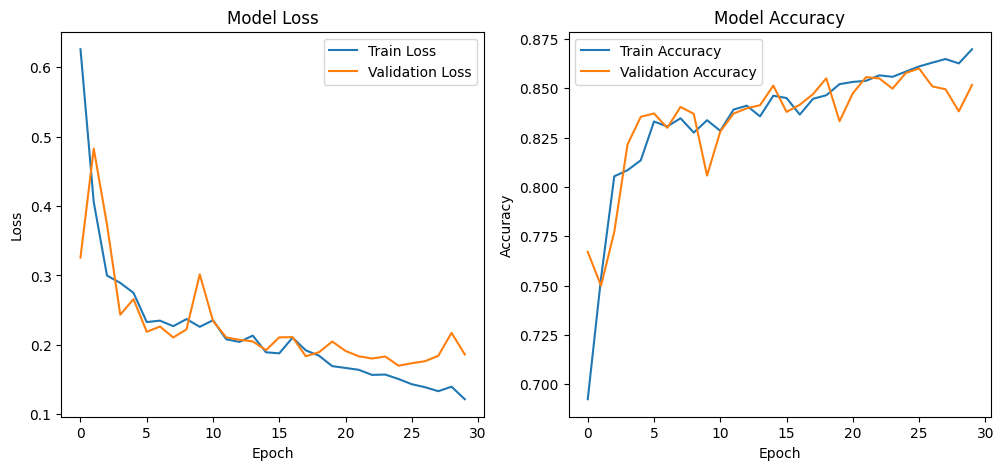

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 705ms/step


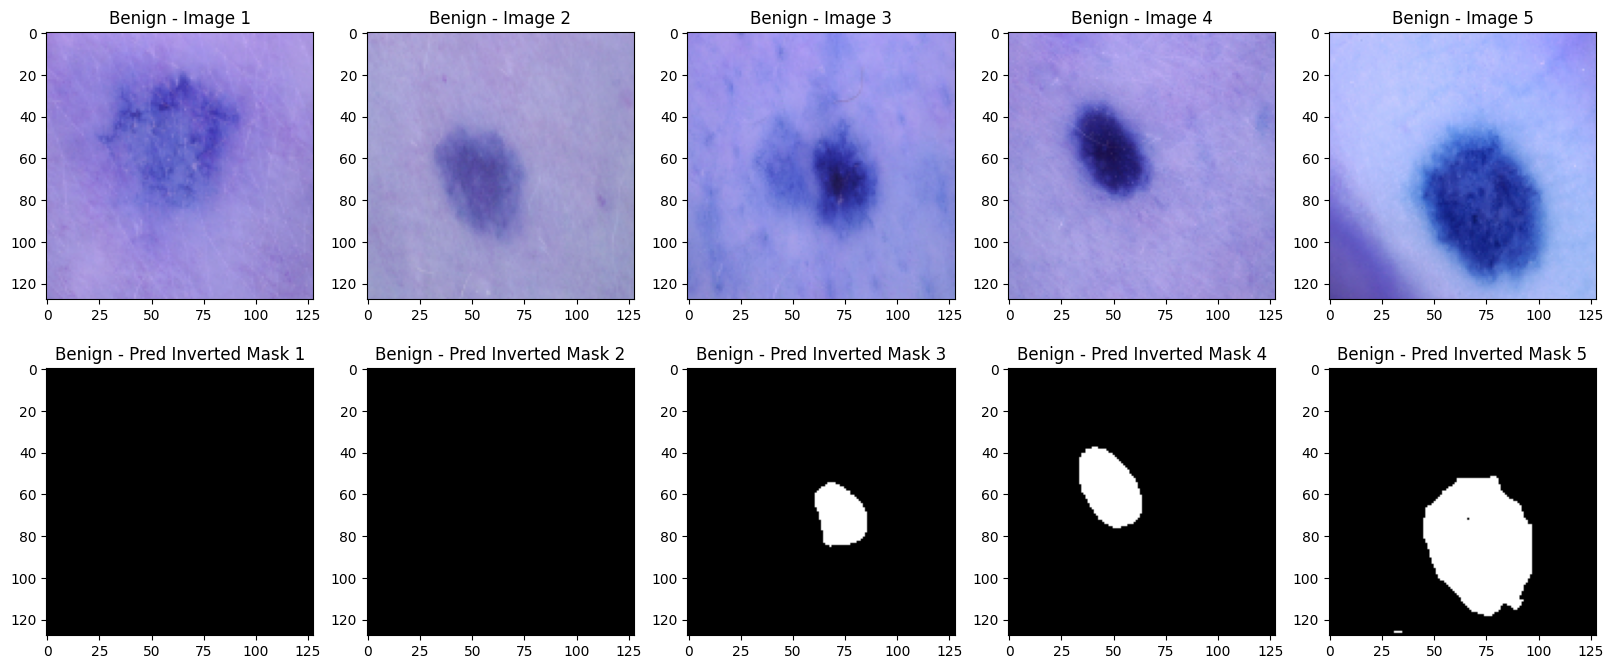

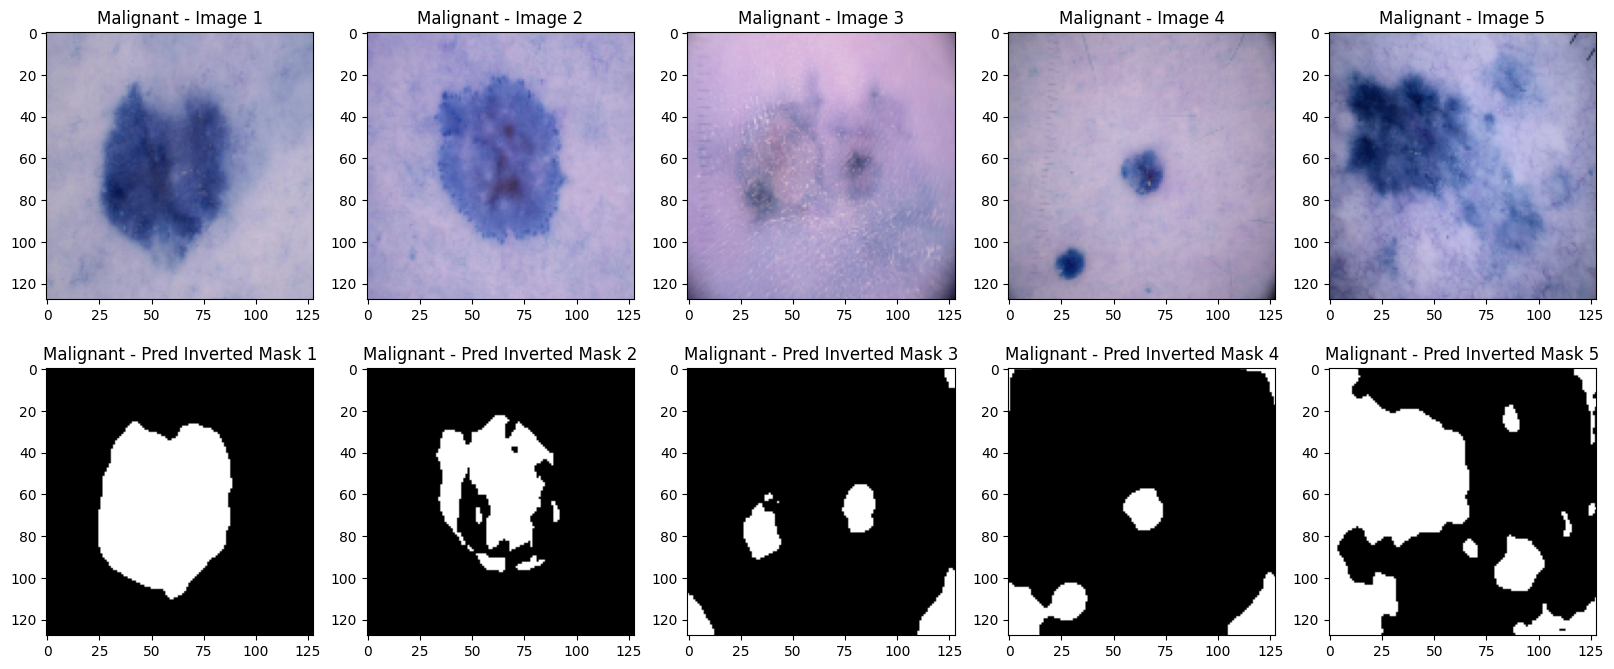

In [ ]:
predictions_benign = best_model.predict(benign_images)
predictions_malignant = best_model.predict(malignant_images)

# Convert predictions to binary and invert them
predictions_binary_benign = (predictions_benign > 0.5).astype(np.uint8)
predictions_inverted_benign = 1 - predictions_binary_benign

predictions_binary_malignant = (predictions_malignant > 0.5).astype(np.uint8)
predictions_inverted_malignant = 1 - predictions_binary_malignant
import matplotlib.pyplot as plt
# Function to display images and predicted inverted masks (no true masks)
def display_images(images, pred_masks, title):
    plt.figure(figsize=(20, 8))
    for i in range(5):
        # Display original images
        plt.subplot(2, 5, i + 1)
        plt.title(f"{title} - Image {i+1}")
        plt.imshow(images[i])

        # Display predicted inverted masks
        plt.subplot(2, 5, i + 6)
        plt.title(f"{title} - Pred Inverted Mask {i+1}")
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')

    plt.show()

# Display 5 benign images with predicted inverted masks
display_images(benign_images[:5], predictions_inverted_benign[:5], title="Benign")

# Display 5 malignant images with predicted inverted masks
display_images(malignant_images[:5], predictions_inverted_malignant[:5], title="Malignant")


In [ ]:
best_model.save('/content/drive/MyDrive/best_model_segnet_BEE_updatedmask_hehehe.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!


In [ ]:
from scipy.special import gamma
import numpy as np

class ANBOOptimizer:
    def __init__(self, model, lb, ub, population_size=30, max_iter=1):  # Set max_iter to 1
        self.model = model
        self.lb = lb
        self.ub = ub
        self.population_size = population_size
        self.max_iter = max_iter

        # Keep track of the layer weight shapes
        self.weight_shapes = [w.shape for w in model.get_weights()]

        # Compute total number of weights (flattened size)
        self.total_weights = sum(np.prod(shape) for shape in self.weight_shapes)

        # Initialize the population
        self.population = self.initialize_population()

    def initialize_population(self):
        # Initialize a population of flattened weight vectors
        return [self.lb + np.random.rand(self.total_weights) * (self.ub - self.lb) for _ in range(self.population_size)]

    def flatten_weights(self, weights):
        # Flatten the model weights into a 1D array
        return np.concatenate([w.flatten() for w in weights])

    def reshape_weights(self, flattened_weights):
        # Reshape the flattened weight vector back to the model's original weight shapes
        reshaped_weights = []
        start = 0
        for shape in self.weight_shapes:
            size = np.prod(shape)
            reshaped_weights.append(flattened_weights[start:start + size].reshape(shape))
            start += size
        return reshaped_weights
    def fitness(self, flattened_weights, X, y_true, batch_size=32):
      reshaped_weights = self.reshape_weights(flattened_weights)
      self.model.set_weights(reshaped_weights)

      num_samples = X.shape[0]
      num_batches = int(np.ceil(num_samples / batch_size))

      total_loss = 0
      for batch in range(num_batches):
          start = batch * batch_size
          end = min(start + batch_size, num_samples)
          X_batch = X[start:end]
          y_batch = y_true[start:end]
          y_pred = self.model.predict(X_batch)

          # Clip predictions to prevent NaNs during loss computation
          y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

          if np.isnan(y_pred).any():
              return np.inf  # Return a large fitness value if NaNs are detected

          total_loss += np.sum((y_pred - y_batch) ** 2)

      mean_loss = total_loss / num_samples
      return mean_loss

    def guided_foraging(self, Su, Su_tar):
        lambda_factor = np.random.normal(0, 1)
        Vu_next = Su_tar + lambda_factor * (Su - Su_tar)
        return np.clip(Vu_next, self.lb, self.ub)

    def levy_flight(self, beta=1.5):
        u = np.random.normal(0, 1)
        v = np.random.normal(0, 1)
        gamma_numerator = gamma(1 + beta) * np.sin(np.pi * beta / 2)
        gamma_denominator = gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)
        levy_constant = (gamma_numerator / gamma_denominator) ** (1 / beta)
        levy_step = u / (np.abs(v) ** (1 / beta)) * levy_constant
        return levy_step

    def update_position(self, Su, Sj, humidity):
        levy_step = self.levy_flight()
        return Su + humidity * (Sj - Su) + levy_step

    def optimize(self, X_train, y_train, patience=3):
        best_solution = None
        best_fitness = float('inf')
        no_improvement = 0

        # Store the original weights before optimization
        original_weights = self.flatten_weights(self.model.get_weights())
        original_fitness = self.fitness(original_weights, X_train, y_train)

        # Run only 1 iteration
        for iteration in range(self.max_iter):
            for i, Su in enumerate(self.population):
                fitness_val = self.fitness(Su, X_train, y_train)


                if fitness_val < best_fitness:
                    best_fitness = fitness_val
                    best_solution = Su
                    no_improvement = 0  # Reset patience counter
                else:
                    no_improvement += 1

                if no_improvement >= patience:
                    break

                # Guided foraging process
                Su_tar = self.population[np.random.randint(self.population_size)]
                Su_next = self.guided_foraging(Su, Su_tar)

                # Random restart
                if np.random.rand() > 0.7:
                    Su_next = self.lb + np.random.rand(self.total_weights) * (self.ub - self.lb)

                # Levy flight and position update
                if np.random.rand() > 0.5:
                    Sj = self.population[np.random.randint(self.population_size)]
                    humidity = np.random.rand()
                    Su_next = self.update_position(Su, Sj, humidity)

                self.population[i] = Su_next

        # Compare the best solution with the original fitness
        if best_fitness < original_fitness:
            self.model.set_weights(self.reshape_weights(best_solution))
        else:
            self.model.set_weights(self.reshape_weights(original_weights))

        return self.model.get_weights(), best_fitness

In [ ]:

lb = -0.0001  # Single lower bound
ub = 0.0001   # Single upper bound

# Initialize the optimizer
optimizer = ANBOOptimizer(r2u_net_model, lb, ub, population_size=4, max_iter=1)

# Run the optimization process
best_weights, best_fitness = optimizer.optimize(X_train, y_train)

# Set the model's weights to the best solution
r2u_net_model.set_weights(best_weights)

NameError: name 'r2u_net_model' is not defined

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

r2u_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = r2u_net_model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=50,
                            batch_size=32,callbacks=[early_stopping])


In [ ]:
y_pred_val = r2u_net_model.predict(X_val)

# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to invert the mask (make segmented part white and background black)
def invert_mask(mask):
    return np.where(mask > 0, 0, 1)  # Inverting the mask

# Function to display the original images and their corresponding inverted masks
def display_segmented_images(images, masks, num=5):
    plt.figure(figsize=(25, 25))
    for i in range(num):
        # Display the original image
        plt.subplot(num, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis('off')

        # Display the corresponding inverted mask
        plt.subplot(num, 2, 2 * i + 2)
        inverted_mask = invert_mask(masks[i].squeeze())  # Inverting the mask
        plt.imshow(inverted_mask, cmap="gray")
        plt.title(" Segmentation Mask")
        plt.axis('off')

    plt.show()

# Display 15 segmented images
display_segmented_images(images, lesion_masks, num=15)


In [ ]:
# Assuming r2u_net is your trained R2U-Net model and benign_images and malignant_images are your image datasets

# Predict segmentation masks using the R2U-Net model
predicted_masks_1 = r2u_net_model.predict(benign_images)  # Predicted masks for benign images
predicted_masks_2 = r2u_net_model.predict(malignant_images)  # Predicted masks for malignant images

# Concatenate all masks (optional, if you want to handle both benign and malignant images together)
predicted_masks = np.concatenate([predicted_masks_1, predicted_masks_2], axis=0)

# Now display the segmented images and masks
display_segmented_images(benign_images, predicted_masks_1, num=5)  # Display benign segmented images
display_segmented_images(malignant_images, predicted_masks_2, num=5)  # Display malignant segmented images


In [ ]:
print(f"Min and Max of Predicted Masks (Benign): {np.min(predicted_masks_1)}, {np.max(predicted_masks_1)}")
print(f"Min and Max of Predicted Masks (Malignant): {np.min(predicted_masks_2)}, {np.max(predicted_masks_2)}")
